In [1]:
import torch
torch.cuda.is_available()

torch.cuda.current_device()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 4060 Ti'

In [2]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [3]:
import os
import pandas as pd
from pathlib import Path


directory_path = r'C:\Users\Marshall\TEST DATA\TEST DATA' #path to the directory containing the files

files = Path(directory_path).glob('FAB_DalbergiaLatifolia_*') #get all the files in the directory

spectra_list = []

for file in files:      #iterate over the files and read them into a pandas dataframe
    file_path = os.path.join(directory_path, file)
    spectrum = pd.read_csv(file,sep= '\t',header = 1)
    spectra_list.append(spectrum)     #append the dataframe to a list



In [4]:
# Check the dimensions of the dataframes

for df in spectra_list:
    print(df.shape)

(825, 2)
(970, 2)
(1193, 2)
(1127, 2)
(1408, 2)
(895, 2)
(1080, 2)
(1276, 2)
(1257, 2)
(1140, 2)
(856, 2)
(507, 2)
(1062, 2)
(894, 2)
(813, 2)
(883, 2)
(762, 2)
(917, 2)
(878, 2)
(1057, 2)
(1100, 2)
(818, 2)


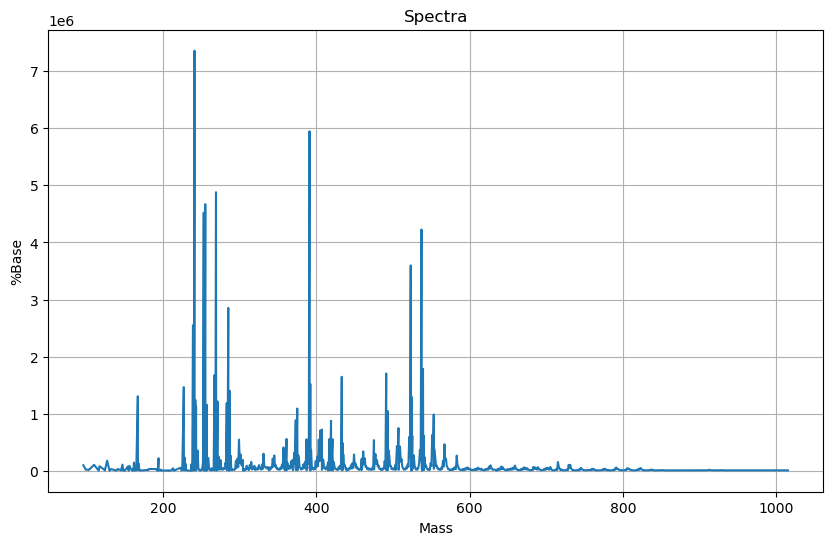

In [5]:
import matplotlib.pyplot as plt

# Assuming spectra_list[0] is the padded spectra you want to plot
df = spectra_list[0]

plt.figure(figsize=(10,6))
plt.plot(df['Mass'], df['%Base'])
plt.title('Spectra')
plt.xlabel('Mass')
plt.ylabel('%Base')
plt.grid(True)
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()     #default range is 0 to 1

# Normalize the %Base values
for df in spectra_list:
   df['%Base'] = scaler.fit_transform(df[['%Base']])   #normalize the %Base column



# Check the first 5 rows of the first dataframe
print(spectra_list[0].head())


       Mass     %Base
0   96.0394  0.013081
1   99.0887  0.002500
2  102.0869  0.002543
3  103.0498  0.001836
4  110.0562  0.013965


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence


# Convert the dataframes to a list of numpy arrays
spectra_list = [df[['Mass', '%Base']].to_numpy() for df in spectra_list]


# Convert to a list of PyTorch tensors
data_tensors = [torch.tensor(seq, dtype=torch.float32) for seq in spectra_list]

# Pad the sequences to the same length
padded_data = pad_sequence(data_tensors, batch_first=True)

# Get the lengths of each sequence before padding
lengths = torch.tensor([len(seq) for seq in data_tensors])

print(padded_data.shape)  # Should be (batch_size, max_sequence_length, num_features)
print(lengths)  # Original lengths of sequences


torch.Size([22, 1408, 2])
tensor([ 825,  970, 1193, 1127, 1408,  895, 1080, 1276, 1257, 1140,  856,  507,
        1062,  894,  813,  883,  762,  917,  878, 1057, 1100,  818])


In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):              
         #input_size is the number of features in the input data, 
         #hidden_size is the number of hidden units in the GRU,
         #output_size is the number of features in the output data
        super(Generator, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        #  input_size: The number of expected features in the input x
        #  hidden_size: The number of features in the hidden state h
        #  batch_first: If True, then the input and output tensors are provided as (batch, seq, feature)
        self.dropout1 = nn.Dropout(0.1)
        # 0.2 is the probability of an element to be zeroed in the tensor x
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.1)
        self.gru3 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout3 = nn.Dropout(0.1)
        self.gru4 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout4 = nn.Dropout(0.1)
        self.gru5 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout5 = nn.Dropout(0.1)
        self.gru6 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout6 = nn.Dropout(0.1)
        self.gru7 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout7 = nn.Dropout(0.1)
        self.gru8 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout8 = nn.Dropout(0.1)
        self.fc1 = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths): # x: (batch_size, max_sequence_length, num_features)   # lengths: Original lengths of sequences before padding
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False) # enforce_sorted=False: If True, the input is expected to contain sequences sorted by length in a decreasing order # packed_x: Packed sequence with lengths data for each sequence in a batch # hidden: Tensor containing the initial hidden state for each element in the batch (num_layers * num_directions, batch, hidden_size)
        packed_x, _ = self.gru1(packed_x)
        residual = packed_x # Save the output of the first GRU layer for later
        
        packed_x, _ = self.gru2(packed_x)
        unpacked_x, lengths = pad_packed_sequence(packed_x, batch_first=True)  # Unpack the sequence
        residual_unpacked, _ = pad_packed_sequence(residual, batch_first=True)  # Unpack the residual
        unpacked_x = unpacked_x + residual_unpacked  # Add the residual connection
        unpacked_x = self.dropout2(unpacked_x)
        packed_x = pack_padded_sequence(unpacked_x, lengths, batch_first=True, enforce_sorted=False)
        
        residual = packed_x # Save the output of the second GRU layer for later
        packed_x, _ = self.gru3(packed_x)
        unpacked_x, lengths = pad_packed_sequence(packed_x, batch_first=True)
        residual_unpacked, _ = pad_packed_sequence(residual, batch_first=True)
        unpacked_x = unpacked_x + residual_unpacked  # Add the residual connection
        unpacked_x = self.dropout3(unpacked_x)
        packed_x = pack_padded_sequence(unpacked_x, lengths, batch_first=True, enforce_sorted=False)
        
        residual = packed_x # Save the output of the third GRU layer for later
        packed_x, _ = self.gru4(packed_x)
        unpacked_x, lengths = pad_packed_sequence(packed_x, batch_first=True)
        residual_unpacked, _ = pad_packed_sequence(residual, batch_first=True)
        unpacked_x = unpacked_x + residual_unpacked  # Add the residual connection
        unpacked_x = self.dropout4(unpacked_x)
        packed_x = pack_padded_sequence(unpacked_x, lengths, batch_first=True, enforce_sorted=False)
        
        residual = packed_x # Save the output of the fourth GRU layer for later
        packed_x, _ = self.gru5(packed_x)
        unpacked_x, lengths = pad_packed_sequence(packed_x, batch_first=True)
        residual_unpacked, _ = pad_packed_sequence(residual, batch_first=True)
        unpacked_x = unpacked_x + residual_unpacked  # Add the residual connection
        unpacked_x = self.dropout5(unpacked_x)
        packed_x = pack_padded_sequence(unpacked_x, lengths, batch_first=True, enforce_sorted=False)

        residual = packed_x # Save the output of the fifth GRU layer for later
        packed_x, _ = self.gru6(packed_x)
        unpacked_x, lengths = pad_packed_sequence(packed_x, batch_first=True)
        residual_unpacked, _ = pad_packed_sequence(residual, batch_first=True)
        unpacked_x = unpacked_x + residual_unpacked  # Add the residual connection
        unpacked_x = self.dropout6(unpacked_x)
        packed_x = pack_padded_sequence(unpacked_x, lengths, batch_first=True, enforce_sorted=False)

        residual = packed_x # Save the output of the sixth GRU layer for later
        packed_x, _ = self.gru7(packed_x)
        unpacked_x, lengths = pad_packed_sequence(packed_x, batch_first=True)
        residual_unpacked, _ = pad_packed_sequence(residual, batch_first=True)
        unpacked_x = unpacked_x + residual_unpacked  # Add the residual connection
        unpacked_x = self.dropout7(unpacked_x)
        packed_x = pack_padded_sequence(unpacked_x, lengths, batch_first=True, enforce_sorted=False)

        residual = packed_x # Save the output of the seventh GRU layer for later
        packed_x, _ = self.gru8(packed_x)
        unpacked_x, lengths = pad_packed_sequence(packed_x, batch_first=True) # unpacked_x: Tensor containing the output features h_t from the last layer of the GRU, for each t (batch, seq_len, num_directions * hidden_size) # lengths: Original lengths of sequences before padding
        residual_unpacked, _ = pad_packed_sequence(residual, batch_first=True)
        unpacked_x = unpacked_x + residual_unpacked  # Add the residual connection
        unpacked_x = self.dropout8(unpacked_x)
        packed_x = pack_padded_sequence(unpacked_x, lengths, batch_first=True, enforce_sorted=False)
        
        x, _ = pad_packed_sequence(packed_x, batch_first=True)
        # x: Tensor containing the output features h_t from the last layer of the GRU, for each t (batch, seq_len, num_directions * hidden_size)
        x = self.fc3(x)
        return x


In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru2 = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_x, _ = self.gru1(packed_x)
        packed_x, _ = self.gru2(packed_x)
        x, _ = pad_packed_sequence(packed_x, batch_first=True)
        x = self.fc(x[:, -1, :])  # Use the last hidden state
        x = self.sigmoid(x)
        return x


In [37]:
# import torch.autograd as autograd

# def gradient_penalty(discriminator, real_data, fake_data, lengths, device):
#     alpha = torch.rand(real_data.size(0), 1, 1).to(device)
#     interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
#     lengths = lengths.cpu()
#     d_interpolates = discriminator(interpolates, lengths)
    
#     fake = torch.ones(d_interpolates.size(), requires_grad=False).to(device)
    
#     gradients = autograd.grad(
#         outputs=d_interpolates,
#         inputs=interpolates,
#         grad_outputs=fake,
#         create_graph=True,
#         retain_graph=True,
#         only_inputs=True
#     )[0]
    
#     gradients = gradients.view(gradients.size(0), -1)
#     gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
#     return gradient_penalty

In [10]:
# Define generator and discriminator models
input_size = padded_data.shape[2]  # Number of features
hidden_size = 250 # Number of hidden units in the GRU layers of the generator and discriminator models 
output_size = padded_data.shape[2]  # Number of features

generator = Generator(input_size, hidden_size, output_size)
# The generator model takes the input_size features and outputs the output_size features

discriminator = Discriminator(output_size, hidden_size)
# The discriminator model takes the output_size features from the generator and outputs a single value between 0 and 1

# Define optimizer and loss function
lr = 0.0005 # Learning rate for the optimizer default is 0.001   
beta1 = 0.99 # Beta1 hyperparameter for the Adam optimizer default is 0.9
optimizer_G = optim.Adam(generator.parameters(), lr=lr, weight_decay=0.0001) # Adam optimizer for the generator
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, weight_decay= 0.0001) # Adam optimizer for the discriminator
criterion = nn.BCELoss() # Binary cross-entropy loss function




In [11]:
# Assume we treat the data as sequences of length equal to the number of rows in the data
sequence_length = padded_data.shape[1]
num_features = padded_data.shape[2]



Epoch [0/600]  Loss D: 0.6504340171813965, Loss G: 2.0482287406921387


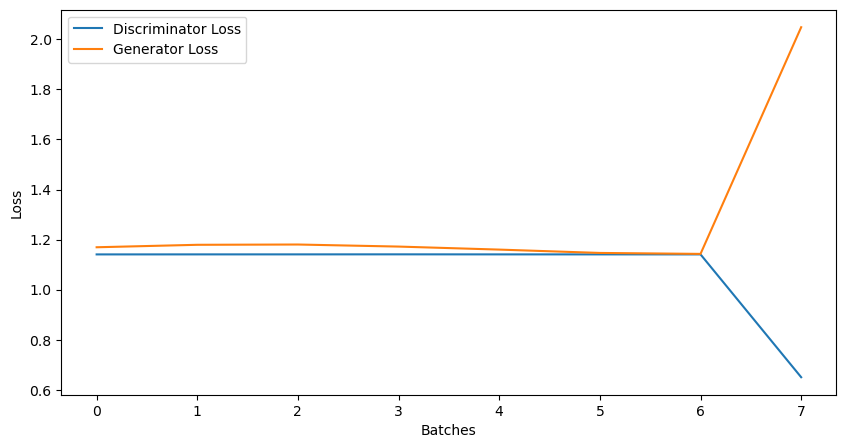

Epoch [100/600]  Loss D: 1.1485387086868286, Loss G: 0.9135900139808655


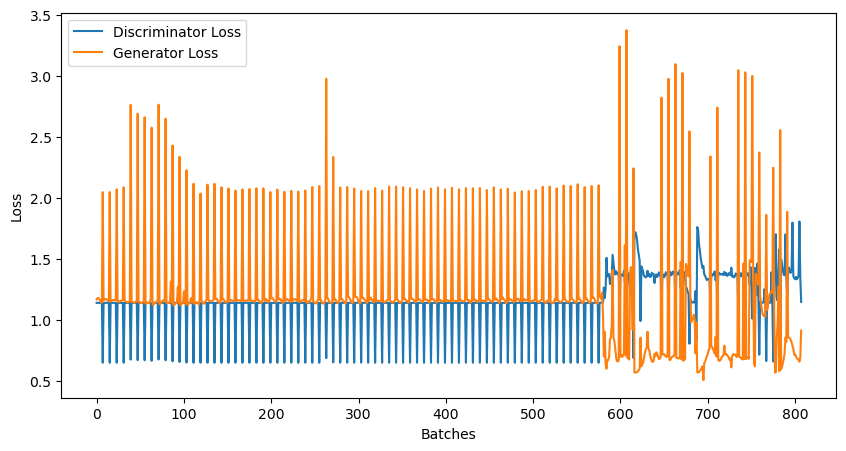

Epoch [200/600]  Loss D: 0.7261216044425964, Loss G: 1.6616166830062866


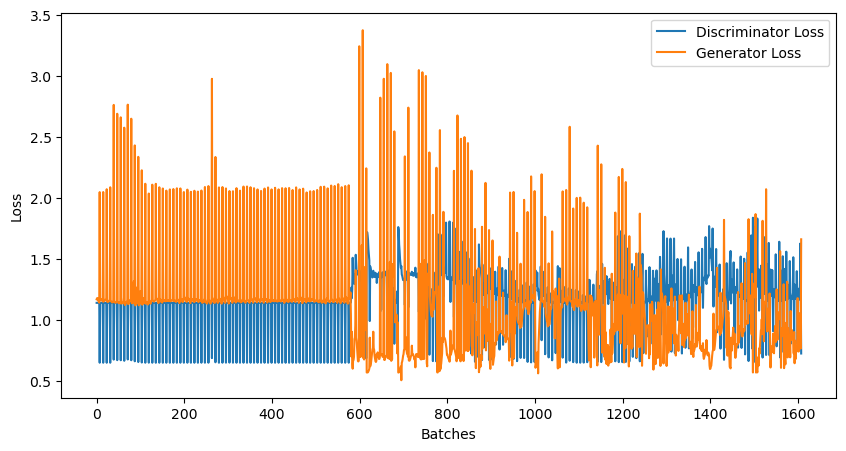

Epoch [300/600]  Loss D: 0.6557501554489136, Loss G: 2.32521915435791


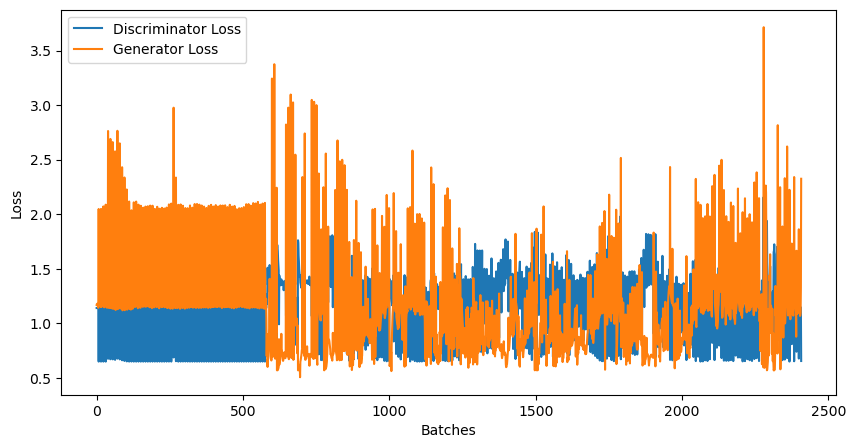

Epoch [400/600]  Loss D: 0.6501868963241577, Loss G: 2.0891711711883545


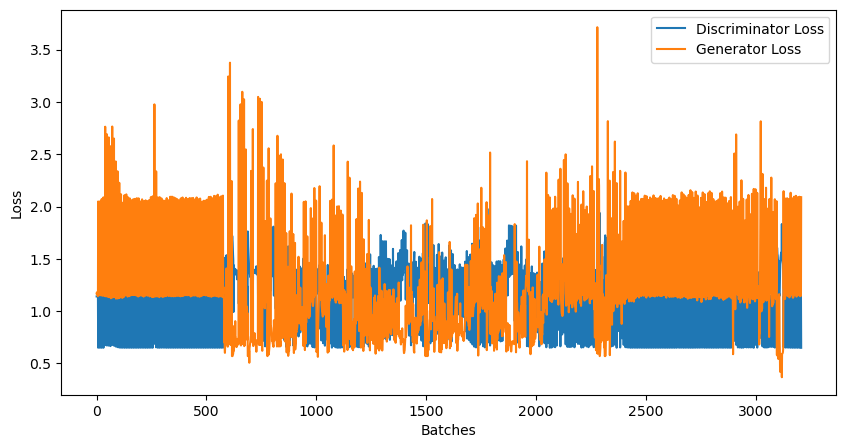

Epoch [500/600]  Loss D: 1.357280969619751, Loss G: 0.7790805697441101


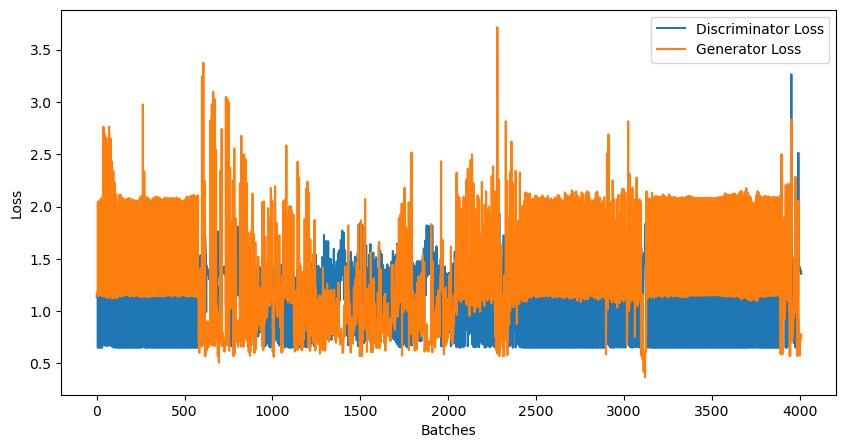

In [15]:
import matplotlib.pyplot as plt
import torch.nn.utils as utils

def generate_noise(batch_size, sequence_length, num_features):
    return torch.randn(batch_size, sequence_length, num_features)

def train_gan(generator, discriminator, criterion, optimizer_G, optimizer_D, padded_data, lengths, epochs, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)
    
    smooth_real_label = 0.9
    smooth_fake_label = 0.1
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        for i in range(0, len(padded_data), batch_size):     #iterate over the data in batches
            real_data = padded_data[i:i + batch_size].to(device)
            real_lengths = lengths[i:i + batch_size].cpu()  # Ensure lengths are kept on the CPU
            
            # Train Discriminator
            optimizer_D.zero_grad()
            
            # Real data
            label = torch.full((real_data.size(0),), smooth_real_label, dtype=torch.float32, device=device)
            real_output = discriminator(real_data, real_lengths).view(-1)
            d_loss_real = criterion(real_output, label)
            #d_loss_real = criterion(output, label)
            d_loss_real.backward()
            
            # Fake data
            noise = generate_noise(real_data.size(0), real_data.size(1), real_data.size(2)).to(device)
            fake_data = generator(noise, real_lengths)
            label.fill_(smooth_fake_label)
            fake_output = discriminator(fake_data.detach(), real_lengths).view(-1)
            d_loss_fake = criterion(fake_output, torch.full_like(fake_output, smooth_fake_label))
            #d_loss_fake = criterion(output, label)
            d_loss_fake.backward()
            
            # Gradient clipping for discriminator
            utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            optimizer_D.step()
            
            d_losses.append(d_loss.item())
            
            # Train Generator
            optimizer_G.zero_grad()
            label.fill_(smooth_real_label)
            output = discriminator(fake_data, real_lengths).view(-1)
            g_loss = criterion(output, label)
            g_loss.backward()

            # Gradient clipping for generator
            utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

            optimizer_G.step()
            
            g_losses.append(g_loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}]  Loss D: {d_loss.item()}, Loss G: {g_loss.item()}")
            
            plt.figure(figsize=(10, 5))
            plt.plot(d_losses, label='Discriminator Loss')
            plt.plot(g_losses, label='Generator Loss')
            plt.xlabel('Batches')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

# Train the GAN
train_gan(generator, discriminator, criterion, optimizer_G, optimizer_D, padded_data, lengths, epochs=600, batch_size=3)


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')
generated_samples_np = generated_samples.detach().numpy()

# Number of samples to plot
num_samples = 3
# Plot real vs. generated spectra
for i in range(num_samples):
    plt.figure(figsize=(10, 5))

    # Plot real spectrum
    plt.subplot(1, 2, 1)
    plt.plot(padded_data[0, :, 0], padded_data[0, :, 1])
    plt.title('Real Spectrum')

    # Plot generated spectrum
    plt.subplot(1, 2, 2)
    plt.plot(generated_samples_np[i, :, 0], generated_samples_np[i, :, 1])
    plt.title('Generated Spectrum')

    plt.show()

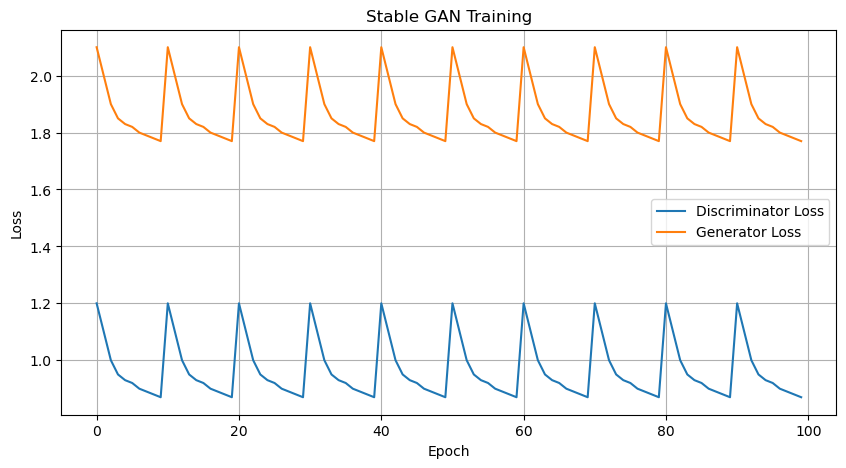

In [14]:
import matplotlib.pyplot as plt

# Example data for stable training
epochs = 100
d_losses = [1.2, 1.1, 1.0, 0.95, 0.93, 0.92, 0.90, 0.89, 0.88, 0.87] * 10
g_losses = [2.1, 2.0, 1.9, 1.85, 1.83, 1.82, 1.80, 1.79, 1.78, 1.77] * 10

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Stable GAN Training')
plt.legend()
plt.grid(True)
plt.show()
